# Comparing methods of hurricane forecast uncertainty
##### author: Elizabeth A. Barnes, Randal J. Barnes and Mark DeMaria
##### version: v0.1.0

```
conda create --name env-hurr-tfp python=3.9
conda activate env-hurr-tfp
pip install tensorflow==2.7.0
pip install tensorflow-probability==0.15.0
pip install --upgrade numpy scipy pandas statsmodels matplotlib seaborn 
pip install --upgrade palettable progressbar2 tabulate icecream flake8
pip install --upgrade keras-tuner sklearn
pip install --upgrade jupyterlab black isort jupyterlab_code_formatter
pip install silence-tensorflow
pip install tqdm
```

Use the command
```python -m pip freeze > requirements.txt```
to make a pip installation list.

In [1]:
import datetime
import os
import pickle
import pprint
import time

import experiment_settings
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from build_data import build_hurricane_data
from build_model import build_shash_model, build_bnn_model
from custom_loss import compute_shash_NLL, compute_NLL
from custom_metrics import CustomMAE, InterquartileCapture, SignTest
from model_diagnostics import plot_history
from save_model_run import save_model_run
from sklearn import preprocessing
from tensorflow.keras import optimizers
from training_instrumentation import TrainingInstrumentation
from silence_tensorflow import silence_tensorflow
import tensorflow_probability as tfp

silence_tensorflow()

In [2]:
__author__ = "Randal J Barnes and Elizabeth A. Barnes"
__version__ = "14 January 2022"

EXP_NAME = "intensity7_EPCP72"

DATA_PATH = "data/"
MODEL_PATH = "saved_models/"

In [3]:
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["figure.dpi"] = 150
np.warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

settings = experiment_settings.get_settings(EXP_NAME)
pprint.pprint(settings, width=80)

{'act_fun': 'relu',
 'basin': 'EP|CP',
 'batch_size': 64,
 'filename': 'nnfit_vlist_intensity_and_track_extended.dat',
 'hiddens': [30, 20],
 'leadtime': 72,
 'learning_rate': 0.0001,
 'momentum': 0.9,
 'n_epochs': 25000,
 'n_train': 'max',
 'n_val': 512,
 'nesterov': True,
 'patience': 100,
 'ridge_param': 0.0,
 'rng_seed': [605, 122, 786, 311, 999],
 'target': 'intensity',
 'uncertainty_type': 'bnn',
 'undersample': False}


## Start looping through random seeds

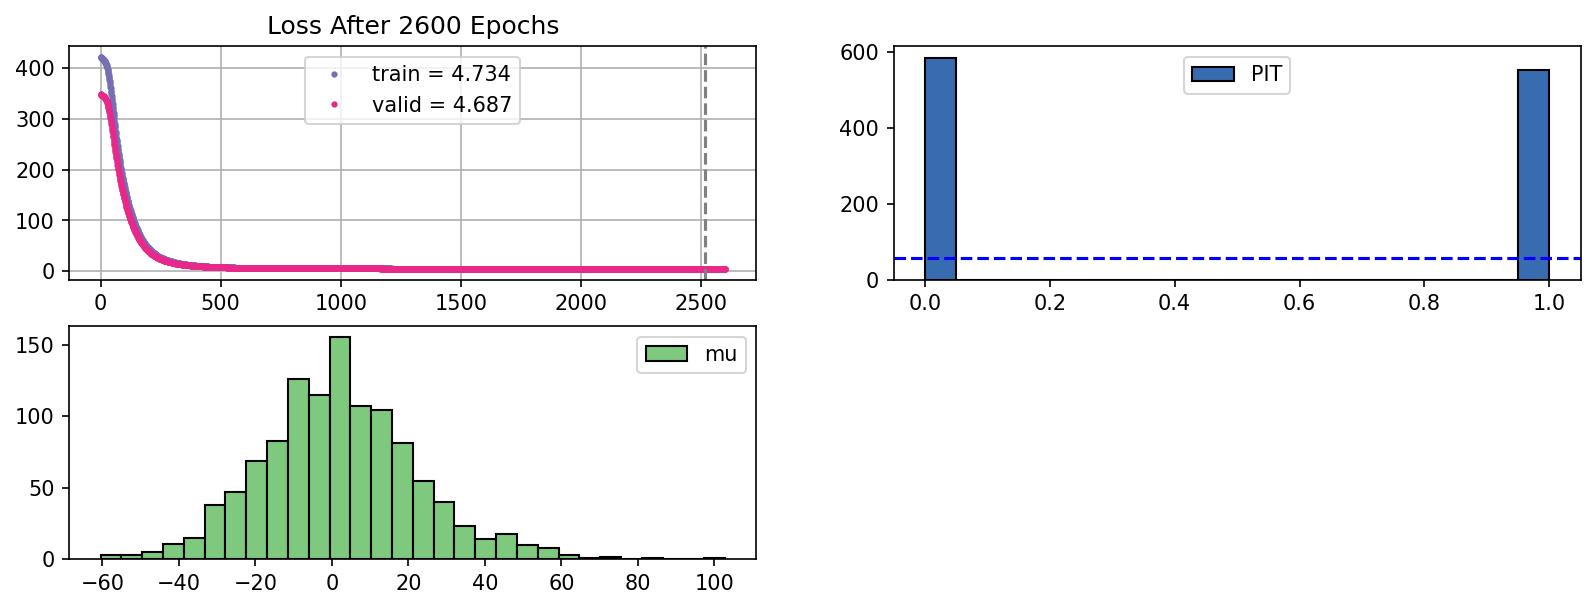

Restoring model weights from the end of the best epoch: 2519.
Epoch 02619: early stopping
{'best_epoch': 2518,
 'elased_time': 71.33350491523743,
 'loss_train': 4.775597095489502,
 'loss_valid': 4.677743911743164,
 'network_seed': 999}
no mae metric, skipping plot
no interquartile_capture, skipping plot
no sign-test, skipping plot


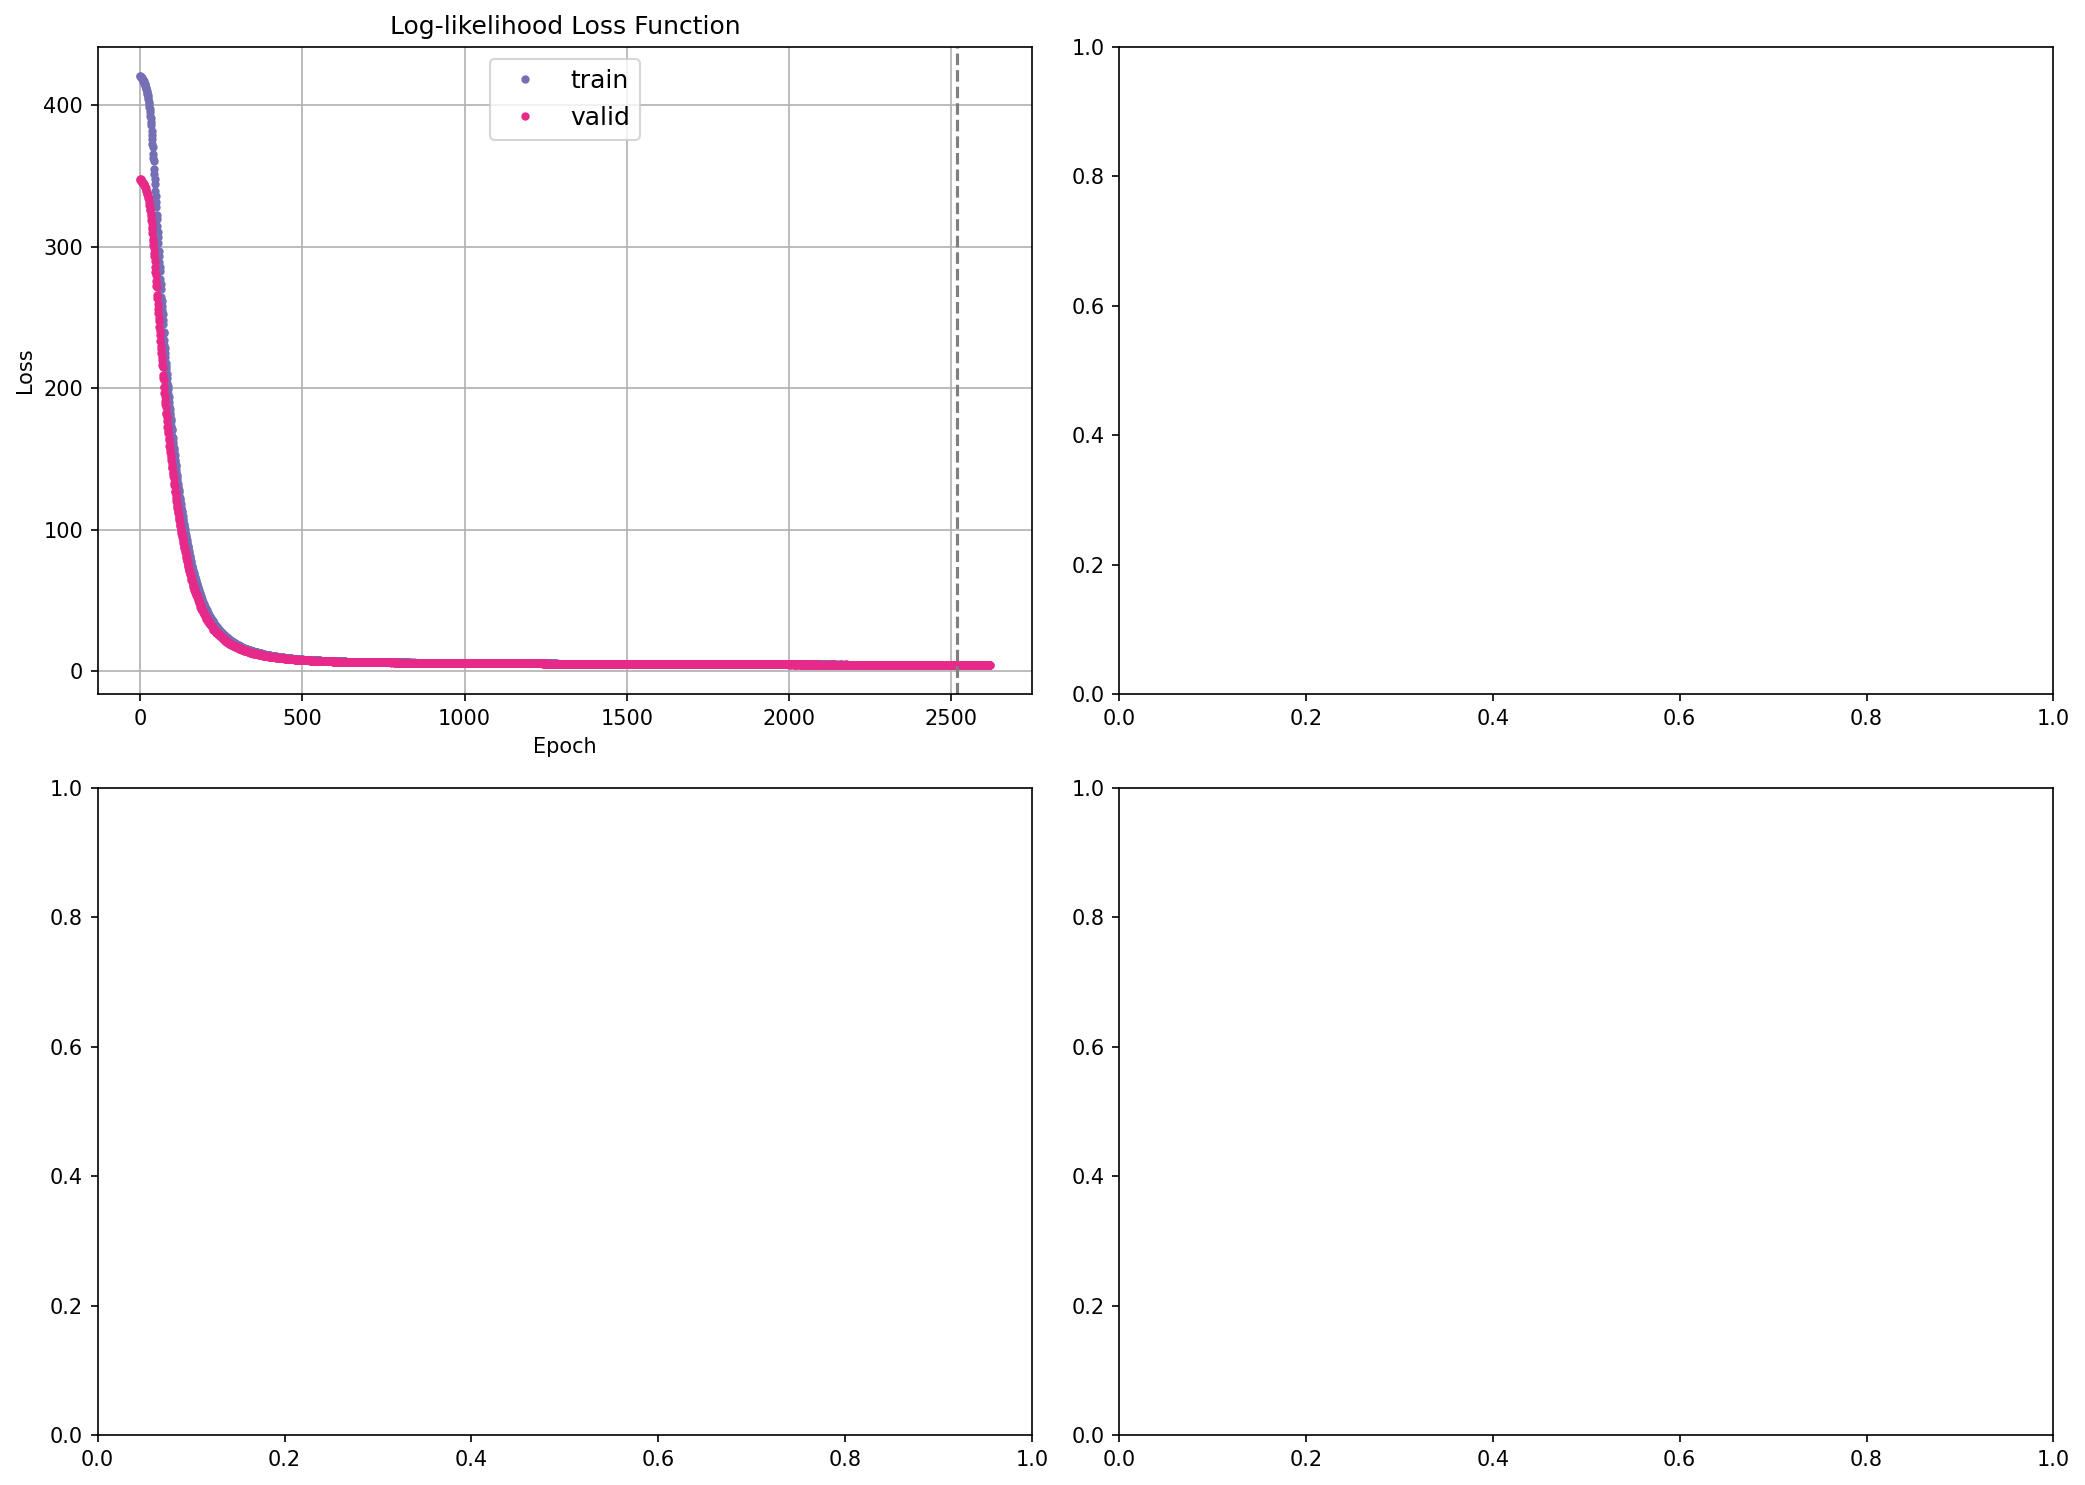

unable to save the model, skipping and saving the weights.


In [4]:
RNG_SEED_LIST = np.copy(settings['rng_seed'])
NETWORK_SEED_LIST = [1701, 5552, 8529, 4440, 2657,]

for rng_seed in RNG_SEED_LIST:
    settings['rng_seed'] = rng_seed
    pprint.pprint(settings['rng_seed'], width=80)

    # build the intensity data tensors
    (
        x_train,
        onehot_train,
        x_val,
        onehot_val,
        x_eval,
        onehot_eval,    
        data_summary,
        df_val,
        df_eval,
    ) = build_hurricane_data(DATA_PATH, settings, verbose=2)


    # define the callbacks
    earlystoping_callback = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        mode="min",
        patience=settings["patience"],
        restore_best_weights=True,
        verbose=1,
    )

    training_callback = TrainingInstrumentation(
        x_train,
        onehot_train,
        interval=50,
    )

    callbacks = [earlystoping_callback, training_callback]

    # set network seed and train the model
    NETWORK_SEED_LIST = [settings["rng_seed"]]

    for network_seed in NETWORK_SEED_LIST:
        tf.random.set_seed(network_seed)  # This sets the global random seed.

        # Create the model name.
        model_name = (
            EXP_NAME + "_" + settings["uncertainty_type"] + '_' + f"network_seed_{network_seed}_rng_seed_{settings['rng_seed']}"
        )
        pprint.pprint(model_name)

        # Make, compile, and train the model
        tf.keras.backend.clear_session()

        if settings["uncertainty_type"] == "bnn":       
            model = build_bnn_model(
                x_train,
                onehot_train,
                hiddens=settings["hiddens"],
                output_shape=onehot_train.shape[1],
                ridge_penalty=settings["ridge_param"],
                act_fun=settings["act_fun"],
            )        

            model.compile(
                optimizer=optimizers.Adam(
                    learning_rate=settings["learning_rate"],
                ),
                loss=compute_NLL,
            )        

        elif settings["uncertainty_type"][:5] == "shash":   
            model = build_shash_model(
                x_train,
                onehot_train,
                hiddens=settings["hiddens"],
                output_shape=onehot_train.shape[1],
                ridge_penalty=settings["ridge_param"],
                act_fun=settings["act_fun"],
            )

            model.compile(
                optimizer=optimizers.SGD(
                    learning_rate=settings["learning_rate"],
                    momentum=settings["momentum"],
                    nesterov=settings["nesterov"],
                ),
                loss=compute_shash_NLL,
                metrics=[
                    CustomMAE(name="custom_mae"),
                    InterquartileCapture(name="interquartile_capture"),
                    SignTest(name="sign_test"),
                ],
            )


        model.summary()

        start_time = time.time()
        history = model.fit(
            x_train,
            onehot_train,
            validation_data=(x_val, onehot_val),
            batch_size=settings["batch_size"],
            epochs=settings["n_epochs"],
            shuffle=True,
            verbose=0,
            callbacks=callbacks,
        )
        stop_time = time.time()

        # Display the results, and save the model rum.
        best_epoch = np.argmin(history.history["val_loss"])
        fit_summary = {
            "network_seed": network_seed,
            "elased_time": stop_time - start_time,
            "best_epoch": best_epoch,
            "loss_train": history.history["loss"][best_epoch],
            "loss_valid": history.history["val_loss"][best_epoch],
        }
        pprint.pprint(fit_summary, width=80)
        plot_history(history, model_name)

        save_model_run(
            data_summary,
            fit_summary,
            model,
            MODEL_PATH,
            model_name,
            settings,
            __version__,
        )